In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset, Subset

In [3]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
import torch.nn.functional as F
# from torchvision import datasets, transforms

In [4]:
import snntorch as snn
import snntorch.spikeplot as splt
# from IPython.display import HTML

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [6]:

DATASET_PATH = Path('SEED')
EMOTIONS = {
    'Neutral': 0,
    'Happy': 1,
    'Sad': 2,
    'Anger': 3,
    'Fear': 4,
    'Disgust': 5,
    'Surprise': 6
}
TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.1

HIDDEN_SIZE = 256
LAYER_COUNT = 4

BATCH_SIZE = 64
LEARNING_RATE = 1e-4
GRADIENT_CLIPPING_MAX_NORM = 0.5
MAX_EPOCHS = 2000
EARLY_STOPPING_PATIENCE = 350
PRINT_FREQUENCY_EPOCHS = 10


NUM_STEPS = 10  # Adjust for poisson temporal depth
FIXED_SEQ_LEN = 70



In [7]:

class SeedDataset(Dataset):
    def __init__(self):
        self.features = []
        for subject_index in range(1, 21):
            subject_features = sio.loadmat(str(DATASET_PATH / 'EEG_features'
                                               / f'{subject_index}.mat'))
            for video_index in range(1, 81):
                de_features = subject_features[f'de_LDS_{video_index}']
                # Flatten the frequency band and EEG channel dimensions.
                de_features = de_features.reshape(de_features.shape[0], -1)
                # Shape: (sequence length, input size (5 * 62))
                self.features.append(de_features)
        labels = pd.read_excel(
            DATASET_PATH / 'emotion_label_and_stimuli_order.xlsx', header=None,
            usecols='B:U', skiprows=lambda row_index: row_index % 2 == 0
        )
        labels = labels.values.flatten().tolist()
        labels = [EMOTIONS[label] for label in labels]
        labels = labels * 20
        self.labels = labels

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> tuple[np.ndarray, int]:
        return self.features[idx], self.labels[idx]



In [8]:
dataset = SeedDataset()
row_count = len(dataset)
print(row_count)
print(dataset[0])

1600
(array([[26.35287574, 27.35400046, 27.24510979, ..., 15.19771485,
        15.32183227, 15.35056856],
       [26.35106677, 27.35408187, 27.2440835 , ..., 15.19913513,
        15.32243371, 15.35182064],
       [26.3545593 , 27.35613658, 27.24467413, ..., 15.20061924,
        15.32347101, 15.35357   ],
       ...,
       [26.40828782, 27.35588376, 27.25665373, ..., 15.2133756 ,
        15.33720278, 15.38302023],
       [26.40705078, 27.35320526, 27.25430671, ..., 15.21125846,
        15.33683886, 15.38170078],
       [26.40681781, 27.34966302, 27.25159395, ..., 15.21022576,
        15.33692793, 15.3811932 ]], shape=(15, 310)), 1)


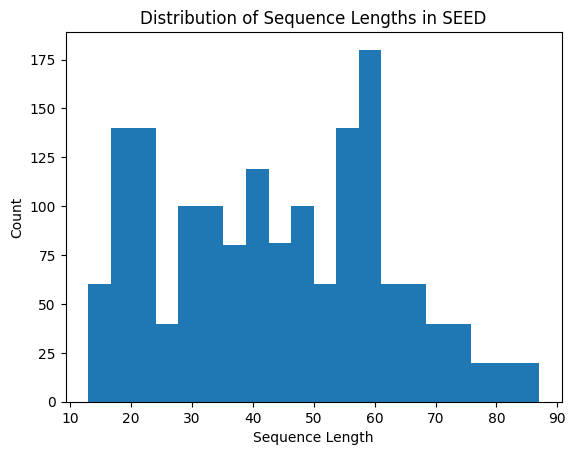

Min: 13, Max: 87, Mean: 43.6


In [9]:

seq_lens = []
for i in range(len(dataset)):
    seq = dataset[i][0]
    seq_lens.append(seq.shape[0])
plt.hist(seq_lens, bins=20)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Sequence Lengths in SEED')
plt.show()
print(f"Min: {min(seq_lens)}, Max: {max(seq_lens)}, Mean: {sum(seq_lens)/len(seq_lens):.1f}")

In [10]:
def poisson_encode(features, num_steps=20):
    """
    features: torch.Tensor, shape (sequence_len, feature_dim)
    Returns: torch.Tensor, shape (num_steps, sequence_len, feature_dim)
    """
    # Normalize to [0, 1] for firing rates
    features_norm = features / features.max()
    # Poisson encoding: at each time step, a spike occurs if rand < rate
    rand = torch.rand((num_steps, *features_norm.shape), device=features.device)
    spikes = (rand < features_norm).float()
    return spikes


In [11]:

def get_data_loaders() -> tuple[DataLoader, DataLoader, DataLoader]:
    dataset = SeedDataset()
    row_count = len(dataset)
    train_indices = list(range(0, int(TRAIN_SPLIT * row_count)))
    validation_indices = list(range(
        int(TRAIN_SPLIT * row_count),
        int((TRAIN_SPLIT + VALIDATION_SPLIT) * row_count)))
    test_indices = list(range(
        int((TRAIN_SPLIT + VALIDATION_SPLIT) * row_count), row_count))
    train_dataset = Subset(dataset, train_indices)
    validation_dataset = Subset(dataset, validation_indices)
    test_dataset = Subset(dataset, test_indices)

    def collate_fn(batch, num_steps=20, fixed_seq_len=70): 
        feature_dim = batch[0][0].shape[1]
        encoded_sequences = []
        for seq, _ in batch:
            seq_tensor = torch.tensor(seq, dtype=torch.float)
            # Truncate if too long
            if seq_tensor.shape[0] > fixed_seq_len:
                seq_tensor = seq_tensor[:fixed_seq_len, :]
            # Pad if too short
            pad_len = fixed_seq_len - seq_tensor.shape[0]
            if pad_len > 0:
                pad = torch.zeros((pad_len, feature_dim), dtype=seq_tensor.dtype, device=seq_tensor.device)
                seq_tensor = torch.cat([seq_tensor, pad], dim=0)
            # Poisson encode
            encoded = poisson_encode(seq_tensor, num_steps=num_steps)
            encoded_sequences.append(encoded)
        batch_spikes = torch.stack(encoded_sequences)
        labels = torch.tensor([label for _, label in batch], dtype=torch.long)
        return batch_spikes, labels


    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=lambda b: collate_fn(b, NUM_STEPS, FIXED_SEQ_LEN)
    )
    validation_loader = DataLoader(
        validation_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=lambda b: collate_fn(b, NUM_STEPS, FIXED_SEQ_LEN)
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=lambda b: collate_fn(b, NUM_STEPS, FIXED_SEQ_LEN)
    )
    return train_loader, validation_loader, test_loader



In [12]:
train_loader, validation_loader, test_loader = get_data_loaders()


In [13]:
batch_spikes, labels = next(iter(train_loader))  # One batch

print(f"Dataloader output shapes:")
print(f"  batch_spikes: {batch_spikes.shape}")
print(f"  labels: {labels.shape}")

Dataloader output shapes:
  batch_spikes: torch.Size([64, 10, 70, 310])
  labels: torch.Size([64])


In [14]:
class LeakySurrogate(nn.Module):
    def __init__(self, beta, z=2, threshold=0.8):
        super(LeakySurrogate, self).__init__()

        # initialize decay rate beta and threshold
        self.beta = beta
        self.threshold = threshold
        self.spike_op = self.SpikeOperator.apply
        self.z = z
        self.mem = None

    # the forward function is called each time we call Leaky
    def forward(self, input_):
        spk = self.spike_op(self.mem - self.threshold, self.z)  # call the Heaviside function
        reset = (spk * self.threshold).detach() # removes spike_op gradient from reset
        self.mem = self.beta * self.mem + input_ - reset
        return spk

    # forward pass: Heaviside function
    @staticmethod
    class SpikeOperator(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input, z):
            """
            In the forward pass we compute a step function of the input Tensor
            and return it. ctx is a context object that we use to stash information which
            we need to later backpropagate our error signals. To achieve this we use the
            ctx.save_for_backward method.
            """
            ctx.save_for_backward(input)
            ctx.z = z
            spk = torch.zeros_like(input)
            spk[input > 0] = 1.0
            return spk

        @staticmethod
        def backward(ctx, grad_output):
            """
            In the backward pass we receive a Tensor we need to compute the
            surrogate gradient of the loss with respect to the input.
            Here we use the fast Sigmoid function with z = 1.
            """
            input, = ctx.saved_tensors
            z = ctx.z
            grad_input = grad_output.clone()
            grad = (
                grad_input
                * z * torch.exp(-z * input)
                / (torch.exp(-z * input) + 1) ** 2
            )
            return grad, None

In [15]:
class SNN(nn.Module):
    def __init__(self, T, beta=0.8, z=1, threshold=1.0):
        super(SNN, self).__init__()
        self.T = T
        self.flatten = nn.Flatten()
        # 1st fully-connected layer
        self.fc1 = nn.Linear(FIXED_SEQ_LEN * 310, 64) # feature_dim = 310
        self.lif1 = LeakySurrogate(beta=beta, z=z, threshold=threshold)
        # 2nd fully-connected layer
        self.fc2 = nn.Linear(64, 7)
        # output layer neurons, whose firing rate will be served as the final prediction
        self.lif2 = LeakySurrogate(beta=beta, z=z, threshold=threshold)

    def init_mem(self, batch_size, feature_num, device):
        return nn.init.kaiming_uniform_(torch.empty(batch_size, feature_num, device=device))

    # define the forward pass
    def forward(self, input_):
        self.lif1.mem = self.init_mem(input_.shape[1], 64, input_.device)
        self.lif2.mem = self.init_mem(input_.shape[1], 7, input_.device)

        output_spikes = 0
        for t in range(self.T):
            x = input_[t]
            x = self.flatten(x)
            x = self.fc1(x)
            spk1 = self.lif1(x)
            x = self.fc2(spk1)
            spk2 = self.lif2(x)
            output_spikes = output_spikes + spk2

        return output_spikes / self.T

In [16]:

print(device)

cuda


In [17]:
# # test
# model = SNN(T=20).to(device)
# batch_spikes = batch_spikes.to(device)
# labels = labels.to(device)

# batch_size, T, seq_len, feat_dim = batch_spikes.shape
# input_dim = seq_len * feat_dim  # 82 * 310 = 25420
# batch_spikes_reshaped = batch_spikes.view(batch_size, T, input_dim)
# batch_spikes_reshaped = batch_spikes_reshaped.permute(1, 0, 2)  # (T, batch, input_dim)

# print("Model input shape:", batch_spikes_reshaped.shape)
# # Model input shape: torch.Size([20, 128, 25420])
# outputs = model(batch_spikes_reshaped)
# print("Model output shape:", outputs.shape)
# # Should be (128, num_classes)

In [18]:
def train_epoch(model: nn.Module, data_loader: DataLoader,
                optimizer: optim.Optimizer, criterion: nn.Module,
                device: torch.device) -> tuple[float, float]:
    model.train()
    total_loss = 0
    total_count = 0
    correct_count = 0
    num_classes = 7  # or make this an argument

    for batch in data_loader:
        optimizer.zero_grad()
        batch_spikes, labels = batch
        batch_spikes = batch_spikes.to(device)
        labels = labels.to(device)
        batch_size, T, seq_len, feat_dim = batch_spikes.shape
        input_dim = seq_len * feat_dim
        batch_spikes = batch_spikes.view(batch_size, T, input_dim)
        batch_spikes = batch_spikes.permute(1, 0, 2)
        outputs = model(batch_spikes)

        # Pick the correct target type for loss
        if isinstance(criterion, torch.nn.MSELoss):
            labels_onehot = torch.zeros(labels.size(0), num_classes, device=labels.device)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
            loss = criterion(outputs, labels_onehot)
        else:  # CrossEntropyLoss
            loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIPPING_MAX_NORM)
        optimizer.step()
        total_loss += loss.item() * labels.shape[0]
        _, predictions = torch.max(outputs, dim=1)
        total_count += labels.shape[0]
        correct_count += (predictions == labels).sum().item()

    avg_loss = total_loss / total_count
    accuracy = correct_count / total_count
    return avg_loss, accuracy



In [19]:
def evaluate(model: nn.Module, data_loader: DataLoader, criterion: nn.Module,
             device: torch.device) -> tuple[float, float]:
    model.eval()
    total_loss = 0
    total_count = 0
    correct_count = 0

    with torch.no_grad():
        for batch in data_loader:
            batch_spikes, labels = batch
            batch_spikes = batch_spikes.to(device)
            labels = labels.to(device)
            batch_size, T, seq_len, feat_dim = batch_spikes.shape
            input_dim = seq_len * feat_dim
            batch_spikes = batch_spikes.view(batch_size, T, input_dim)
            batch_spikes = batch_spikes.permute(1, 0, 2)
            outputs = model(batch_spikes)

            if isinstance(criterion, torch.nn.MSELoss):
                labels_onehot = torch.zeros(labels.size(0), 7, device=labels.device)
                labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
                loss = criterion(outputs, labels_onehot)
            else:  # CrossEntropyLoss
                loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.shape[0]
            _, predictions = torch.max(outputs, dim=1)
            total_count += labels.shape[0]
            correct_count += (predictions == labels).sum().item()

    avg_loss = total_loss / total_count
    accuracy = correct_count / total_count
    return avg_loss, accuracy


In [20]:
def train() -> tuple[list[float], list[float], list[float], list[float]]:
    train_loader, validation_loader, test_loader = get_data_loaders()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}.')
    model = SNN(T=NUM_STEPS, beta=0.8, z=2, threshold=0.8).to(device)  # Set T to match Poisson encoding steps
    optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    best_validation_loss = float('inf')
    best_model = None
    epochs_without_improvement = 0
    for epoch in range(MAX_EPOCHS):
        train_loss, train_accuracy = train_epoch(
            model, train_loader, optimizer, criterion, device)
        validation_loss, validation_accuracy = evaluate(
            model, validation_loader, criterion, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        if epoch == 0 or (epoch + 1) % PRINT_FREQUENCY_EPOCHS == 0:
            print(f'Epoch {epoch + 1}: '
                  f'Train loss: {train_loss:.4f}, '
                  f'Train accuracy: {train_accuracy:.4f}, '
                  f'Validation loss: {validation_loss:.4f}, '
                  f'Validation accuracy: {validation_accuracy:.4f}')
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_model = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
            print(f'Stopping because validation loss did not improve for '
                  f'{EARLY_STOPPING_PATIENCE} epochs. Best validation loss: '
                  f'{best_validation_loss:.4f}')
            break
    model.load_state_dict(best_model)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')
    
    torch.save(model.state_dict(), 'snn_classifier.pt')
    print('Model saved as `snn_classifier.pt`.')
    return (train_losses, train_accuracies, validation_losses, validation_accuracies)


In [21]:
def plot_training_curves(train_losses: list[float],
                         train_accuracies: list[float],
                         validation_losses: list[float],
                         validation_accuracies: list[float]):
    epochs = list(range(1, len(train_losses) + 1))
    plt.figure()
    plt.plot(epochs, train_losses, label='Train loss')
    plt.plot(epochs, validation_losses, label='Validation loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')
    plt.figure()
    plt.plot(epochs, train_accuracies, label='Train accuracy')
    plt.plot(epochs, validation_accuracies, label='Validation accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy.png')
    print('Loss and accuracy curves saved as `loss.png` and `accuracy.png`.')


In [22]:

def main():
    (train_losses, train_accuracies, validation_losses,
     validation_accuracies) = train()
    plot_training_curves(train_losses, train_accuracies, validation_losses,
                         validation_accuracies)


if __name__ == '__main__':
    main()


Using device: cuda.
Epoch 1: Train loss: 1.8970, Train accuracy: 0.2555, Validation loss: 1.8615, Validation accuracy: 0.3187
Epoch 10: Train loss: 1.9466, Train accuracy: 0.1234, Validation loss: 1.9434, Validation accuracy: 0.1187
Epoch 20: Train loss: 1.9462, Train accuracy: 0.1203, Validation loss: 1.9458, Validation accuracy: 0.1187
Epoch 30: Train loss: 1.9453, Train accuracy: 0.1156, Validation loss: 1.9453, Validation accuracy: 0.1313
Epoch 40: Train loss: 1.9458, Train accuracy: 0.1195, Validation loss: 1.9463, Validation accuracy: 0.1250
Epoch 50: Train loss: 1.9465, Train accuracy: 0.1180, Validation loss: 1.9439, Validation accuracy: 0.1187
Epoch 60: Train loss: 1.9464, Train accuracy: 0.1117, Validation loss: 1.9474, Validation accuracy: 0.1062
Epoch 70: Train loss: 1.9477, Train accuracy: 0.1031, Validation loss: 1.9460, Validation accuracy: 0.1313


KeyboardInterrupt: 